## Import various python functions and modules that we need.

In [2]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
workDir = '/home/chantal/Chazy/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

##Import R libraries we'll use.

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr) ;library(dplyr)
library(RColorBrewer)
library(stats)
library(ape)
library(stringr)
library(ade4)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

## Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [6]:
%%R

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = physeq.Bulk %>% filter_taxa(function(x) sum(x) > 0, TRUE)
#physeq.Bulk.Sparsity = filter_taxa(physeq.Bulk, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)

physeq.Bulk.m = physeq.Bulk %>% sample_data

physeq.Bulk.core = prune_samples(physeq.Bulk.m$Land_Management != "PAS" & !(is.na(physeq.Bulk.m$Soil_Temp)),
                                 physeq.Bulk)

physeq.Bulk.m = physeq.Bulk.core %>% sample_data


physeq.Bulk.m = physeq.Bulk.core %>% sample_data
    

physeq.Bulk.core = physeq.Bulk.core %>% transform_sample_counts(function(x) x/sum(x))

physeq.Bulk.m = physeq.Bulk.core %>% sample_data

#print(physeq.Bulk.Sparsity)
print(physeq.Bulk.core)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 128 samples ]
sample_data() Sample Data:       [ 128 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]




### Calculate Unifrac distances between samples.

In [7]:
%%R
method = 'bray'

In [8]:
%%R
registerDoParallel(cores=20)
wunif.dist.nopas = phyloseq::distance(physeq.Bulk.core, 
                      method = method)

In [9]:
%%R
physeq.Bulk.core


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 128 samples ]
sample_data() Sample Data:       [ 128 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


## Bray Curtis vs. Soil Moisture

In [10]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
head(df)

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744


In [11]:
%%R
SD = physeq.Bulk.core %>% sample_data
dist.Temp = dist(SD$Soil_Temp)

In [12]:
%%R
df = melt(as.matrix(wunif.dist.nopas), varnames = c("T1", "T2"))
df.T = melt(as.matrix(dist.Temp, varnames = c('T1', 'T2')))
df.T$tempdist = df.T$value
df.T$T1 = df$T1
df.T$T2 = df$T2
df.T$value = NULL
df.T$Var1 = NULL
df.T$Var2 = NULL

print(head(df))
print(head(df.T))

              T1          T2     value
1    April.NTR.4 April.NTR.4 0.0000000
2 Aug.NTR.3.2015 April.NTR.4 0.4997069
3    April.PTR.3 April.NTR.4 0.6171277
4   July15.NTH.3 April.NTR.4 0.5200756
5      Nov.NTR.1 April.NTR.4 0.7084343
6     June.NTH.2 April.NTR.4 0.5763744
   tempdist             T1          T2
1 0.0000000    April.NTR.4 April.NTR.4
2 8.3666667 Aug.NTR.3.2015 April.NTR.4
3 0.9666667    April.PTR.3 April.NTR.4
4 9.4666667   July15.NTH.3 April.NTR.4
5 7.4333333      Nov.NTR.1 April.NTR.4
6 9.5666667     June.NTH.2 April.NTR.4


In [13]:
%%R
df.tot = left_join(df, df.T)
tail(df.tot)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: c("T1", "T2")

  res = super(Function, self).__call__(*new_args, **new_kwargs)


                  T1             T2  value  tempdist
16379     Sept.PTR.2 Aug.PTH.2.2015 0.5050  2.066667
16380 Oct.NTR.2.2015 Aug.PTH.2.2015 0.6020 12.833333
16381 Aug.PTR.1.2015 Aug.PTH.2.2015 0.4029  0.800000
16382 Aug.PTH.3.2015 Aug.PTH.2.2015 0.3760  0.500000
16383 Aug.PTH.4.2015 Aug.PTH.2.2015 0.2697  0.600000
16384 Aug.PTH.2.2015 Aug.PTH.2.2015 0.0000  0.000000


In [14]:
%%R
head(df.tot, n = 20)
df.tot.sep = df.tot %>% tidyr::separate(T1, c("Month_T1", "Treatment_T1", "Rep_T1"))
df.tot.sep = df.tot.sep %>% tidyr::separate(T2, c("Month_T2", "Treatment_T2", "Rep_T2"))

head(df.tot.sep)

  Month_T1 Treatment_T1 Rep_T1 Month_T2 Treatment_T2 Rep_T2     value  tempdist
1    April          NTR      4    April          NTR      4 0.0000000 0.0000000
2      Aug          NTR      3    April          NTR      4 0.4997069 8.3666667
3    April          PTR      3    April          NTR      4 0.6171277 0.9666667
4   July15          NTH      3    April          NTR      4 0.5200756 9.4666667
5      Nov          NTR      1    April          NTR      4 0.7084343 7.4333333
6     June          NTH      2    April          NTR      4 0.5763744 9.5666667


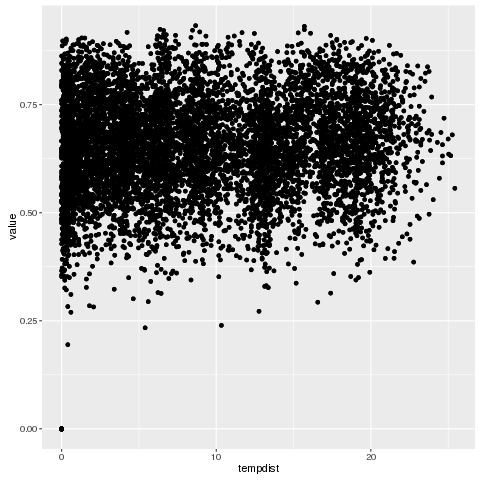

In [15]:
%%R
ggplot(data = df.tot, aes(x = tempdist, y = value)) + geom_point()

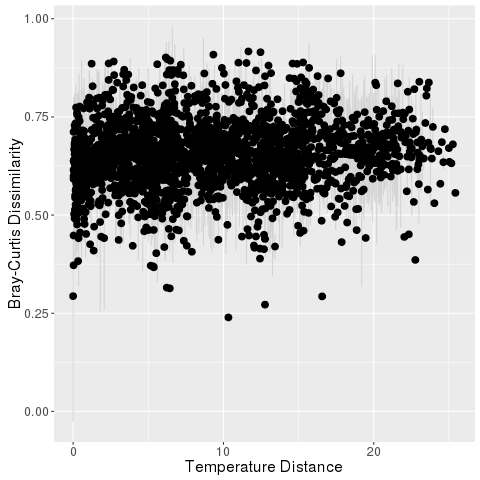

In [16]:
%%R

mean.tempdist = df.tot %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

limits <- aes(ymax = meanval + sdval, ymin = meanval - sdval)

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'light grey')+ 
        geom_point(size = 3) +
    xlab('Temperature Distance') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) 
p

In [17]:
%%R
ggsave(filename = "data/figs/BCvsTemp.png", plot = p, width =8, height =8)

In [18]:
%%R
library(ecodist)
mantel(formula = wunif.dist.nopas ~ dist.Temp, nperm = 10000)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘ecodist’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:vegan’:

    mantel


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:phyloseq’:

    distance


  res = super(Function, self).__call__(*new_args, **new_kwargs)


   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.07014078 0.00270000 0.99740000 0.00310000 0.05330944 0.08965479 


## Split into Treatment

In [43]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Land_Management %>% unique
u.lm

[1] NTR PTR NTH PTH
Levels: NTH NTR PTH PTR


In [44]:
%%R
physeq.Treat.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.l[[d]] = tmp
    print(d)
    physeq.Treat.l[[d]] %>% print
    }

[1] "NTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "PTR"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "NTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "PTH"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [45]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.treat.l = lapply(physeq.Treat.l, calc.MH.dist, cores=nprocs)

In [46]:
%%R
#Sample metadata for split physeq objects
physeq.Treat.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Land_Management == d)
    physeq.Treat.meta[[d]] = sample_data(tmp)
    }


In [47]:
%%R
treatments = c('NTR','PTR', 'NTH', 'PTH')
#treatments = c('N', 'P')
str(treatments)

 chr [1:4] "NTR" "PTR" "NTH" "PTH"


In [48]:
%%R

join_temp = function(treatment, dist.mat, metadata, moistdata){
    
    m = data.frame(metadata[[treatment]])
    dist = dist.mat[[treatment]]
    moist = filter(moistdata, Land_Management == treatment)
    
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))    
    #adding metadata to temperature phlyoseq object
    m$MY = paste(m$Month, m$Year, sep = '-')
    
    #Creating temperature distance matrix
    moistdata = dist(moist$Soil_Temp)
    df.T = melt(as.matrix(moistdata, varnames = c('T1', 'T2')))
    
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Treatment = treatment

  
    return(df.tot)
    
    
}


temp.data = lapply(treatments, join_temp, metadata = physeq.Treat.meta, 
                   dist.mat = MH.dist.treat.l,moistdata = SD)

In [49]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_temp = function(treatment, moistdata){
        
    moist = filter(moistdata, Land_Management == treatment)
    moistdata = dist(moist$Soil_Temp)
    
    return(moistdata)

    
    
}


temp.dist = lapply(treatments, join_temp, moistdata = SD)

In [50]:
%%R

plot_by_treatment = function(df.tempdist) {
    
   treatment = unique(df.tempdist$Treatment)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
   mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Temperature difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(treatment)

return(p) 
    
}

plots = lapply(temp.data, plot_by_treatment)

TableGrob (4 x 1) "arrange": 4 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]
4 4 (4-4,1-1) arrange gtable[layout]


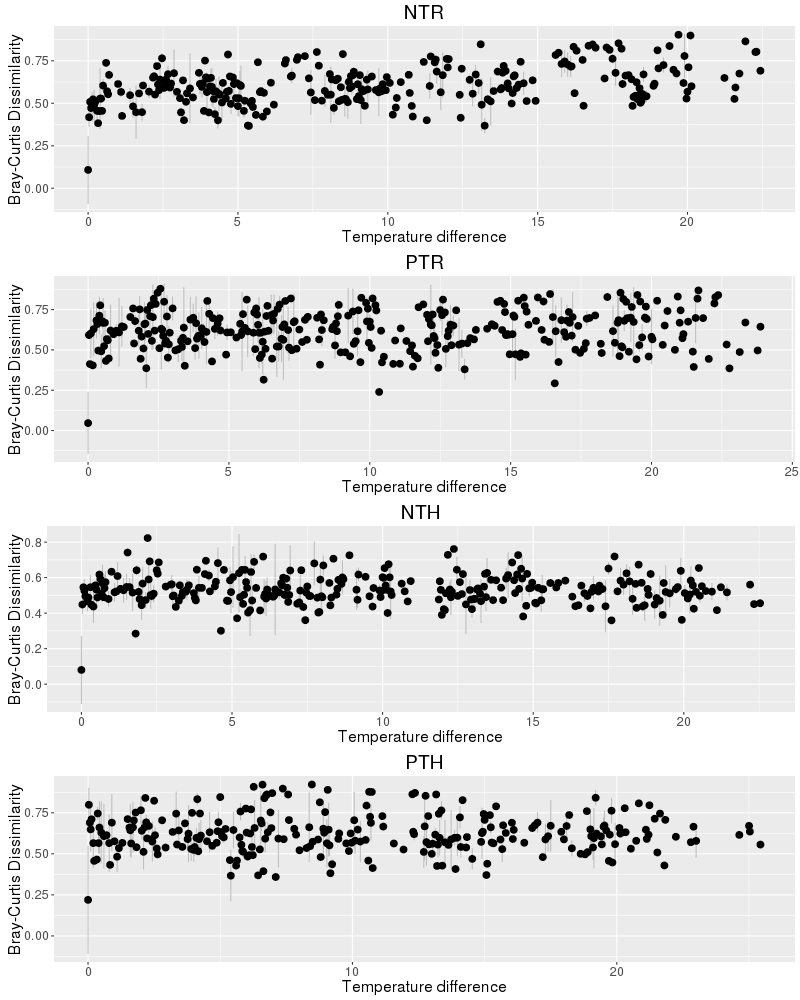

In [51]:
%%R -w 800 -h 1000
p = do.call(grid.arrange, c(plots,list(ncol=1)))
p

In [28]:
%%R
ggsave(filename = "data/figs/BCvsTemp_byTreatment.png", plot = p, width =8, height =12)

In [29]:
%%R
mantel.Temp = function(treatment, df.temp, df.dist) {
    
    df.t = df.temp[[treatment]]
    df.d = df.dist[[treatment]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(c(1,2,3,4), df.temp = temp.dist, df.dist = MH.dist.treat.l, mantel.Temp)

In [30]:
%%R
head(m.temp)

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
 0.4089992  0.0001000  1.0000000  0.0001000  0.3505743  0.4673156 

[[2]]
     mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
 0.032877206  0.269400000  0.730700000  0.574200000 -0.006911048  0.073923411 

[[3]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.03903629  0.74010000  0.26000000  0.50190000 -0.08303701  0.01064965 

[[4]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.01371945  0.55580000  0.44430000  0.82570000 -0.04880022  0.03767765 



### Testing homogeneity of slopes for treatment

In [56]:
%%R
T.data = do.call(rbind, temp.data)
head(T.data)

              T1          T2     value  tempdist Treatment
1    April.NTR.4 April.NTR.4 0.0000000 0.0000000       NTR
2 Aug.NTR.3.2015 April.NTR.4 0.4997069 8.3666667       NTR
3      Nov.NTR.1 April.NTR.4 0.7084343 7.4333333       NTR
4    April.NTR.3 April.NTR.4 0.4553828 0.4666667       NTR
5    April.NTR.2 April.NTR.4 0.5711106 0.6333333       NTR
6     June.NTR.3 April.NTR.4 0.4460035 8.5666667       NTR


In [57]:
%%R
corr = aov(value~tempdist*Treatment, data=T.data)
summary(corr)

                     Df Sum Sq Mean Sq F value Pr(>F)    
tempdist              1   5.40   5.404  233.15 <2e-16 ***
Treatment             3   5.21   1.736   74.92 <2e-16 ***
tempdist:Treatment    3   1.97   0.658   28.38 <2e-16 ***
Residuals          4088  94.75   0.023                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [58]:
%%R
corr2 = aov(value~tempdist+Treatment, data=T.data)
summary(corr2)

              Df Sum Sq Mean Sq F value Pr(>F)    
tempdist       1   5.40   5.404  228.56 <2e-16 ***
Treatment      3   5.21   1.736   73.44 <2e-16 ***
Residuals   4091  96.73   0.024                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [60]:
%%R
anova(corr,corr2)

Analysis of Variance Table

Model 1: value ~ tempdist * Treatment
Model 2: value ~ tempdist + Treatment
  Res.Df    RSS Df Sum of Sq      F    Pr(>F)    
1   4088 94.753                                  
2   4091 96.726 -3   -1.9731 28.375 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Separation by Replicate - temp vs phylogenetic distance

In [31]:
%%R
tbl.meta = physeq.Bulk.core %>% sample_data
u.lm = tbl.meta$Replicate %>% unique
u.lm

[1] 4 3 1 2


In [32]:
%%R
physeq.Rep.l = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.l[[d]] = tmp
    print(d)
    physeq.Rep.l[[d]] %>% print
    }

[1] "4"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "3"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "1"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]
[1] "2"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2199 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2199 taxa by 7 taxonomic ranks ]


In [33]:
%%R
#Calculating Morisita-horn distance for each split physeq obj
calc.MH.dist = function(physeq, cores=cores){
    message('Processing sample...')
    registerDoParallel(cores=cores)
    MH.dist = phyloseq::distance(physeq,
                          method = "bray", 
                          fast = TRUE, 
                          parallel = TRUE, 
                          normalized = FALSE)
    return(MH.dist)
    }

MH.dist.rep.l = lapply(physeq.Rep.l, calc.MH.dist, cores=nprocs)

In [34]:
%%R
#Sample metadata for split physeq objects
physeq.Rep.meta = list()

for (d in as.character(u.lm)){
    # filter by Day and removing h2o controls & mock communities
    tmp = subset_samples(physeq.Bulk.core, Replicate == d)
    physeq.Rep.meta[[d]] = sample_data(tmp)
    }


In [35]:
%%R
replicates = c(4, 3, 1, 2)
str(replicates)

 num [1:4] 4 3 1 2


In [36]:
%%R

join_temp = function(replicate, dist.mat, moistdata){
    
    dist = dist.mat[[as.character(replicate)]]
    moist = filter(moistdata, Replicate == replicate)
    #creating matrix of Morisita-horn distances
    df.melt = melt(as.matrix(dist), varnames = c("T1", "T2"))  
    #Creating moisture distance matrix
    moist2 = dist(moist$Soil_Temp)
    df.T = melt(as.matrix(moist2, varnames = c('T1', 'T2')))
    #Adding sample information
    df.T$tempdist = df.T$value
    df.T$T1 = df.melt$T1
    df.T$T2 = df.melt$T2

    #Removing other variables
    df.T$value = NULL
    df.T$Var1 = NULL
    df.T$Var2 = NULL
    
    
    df.tot = left_join(df.melt, df.T)
    df.tot$Replicate = replicate

  
    return(df.tot)
    
    
}


temp.data = lapply(replicates, join_temp, 
                   dist.mat = MH.dist.rep.l, moistdata = SD)

In [37]:
%%R
str(temp.data)

List of 4
 $ :'data.frame':	1024 obs. of  5 variables:
  ..$ T1       : Factor w/ 32 levels "April.NTR.4",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 32 levels "April.NTR.4",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:1024] 0 0.653 0.675 0.619 0.579 ...
  ..$ tempdist : num [1:1024] 0 4.2 11.07 13.97 1.27 ...
  ..$ Replicate: num [1:1024] 4 4 4 4 4 4 4 4 4 4 ...
 $ :'data.frame':	1024 obs. of  5 variables:
  ..$ T1       : Factor w/ 32 levels "Aug.NTR.3.2015",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 32 levels "Aug.NTR.3.2015",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$ value    : num [1:1024] 0 0.656 0.484 0.584 0.722 ...
  ..$ tempdist : num [1:1024] 0 7.4 1.1 6.8 0.7 ...
  ..$ Replicate: num [1:1024] 3 3 3 3 3 3 3 3 3 3 ...
 $ :'data.frame':	1024 obs. of  5 variables:
  ..$ T1       : Factor w/ 32 levels "Nov.NTR.1","Nov.NTH.1.2015",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ T2       : Factor w/ 32 levels "Nov.NTR.1","Nov.NTH.1.2015",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..$

In [38]:
%%R

##Need to figure out how to include multiple lists in the function itself...
join_rep = function(physeq.meta){
        
    moistdata = dist(physeq.meta$Soil_Temp)
    
    return(moistdata)

    
    
}


temp.dist = lapply(physeq.Rep.meta, join_rep)

In [39]:
%%R

plot_by_replicate = function(df.tempdist) {
    
    replicate = unique(df.tempdist$Replicate)

    df.tempdist$tempdist = round(df.tempdist$tempdist, digits = 3)
    
    mean.tempdist = df.tempdist %>% group_by(tempdist) %>% summarise(meanval = mean(value), sdval = sd(value))

    p = ggplot(data = mean.tempdist, aes(tempdist, meanval)) + geom_errorbar(limits, color = 'grey')+ 
        geom_point(size = 3) +
    xlab('Moisture difference') + ylab('Bray-Curtis Dissimilarity') + 
    theme(text = element_text(size = 16)) + ggtitle(replicate)

return(p) 
    
}

plots = lapply(temp.data, plot_by_replicate)

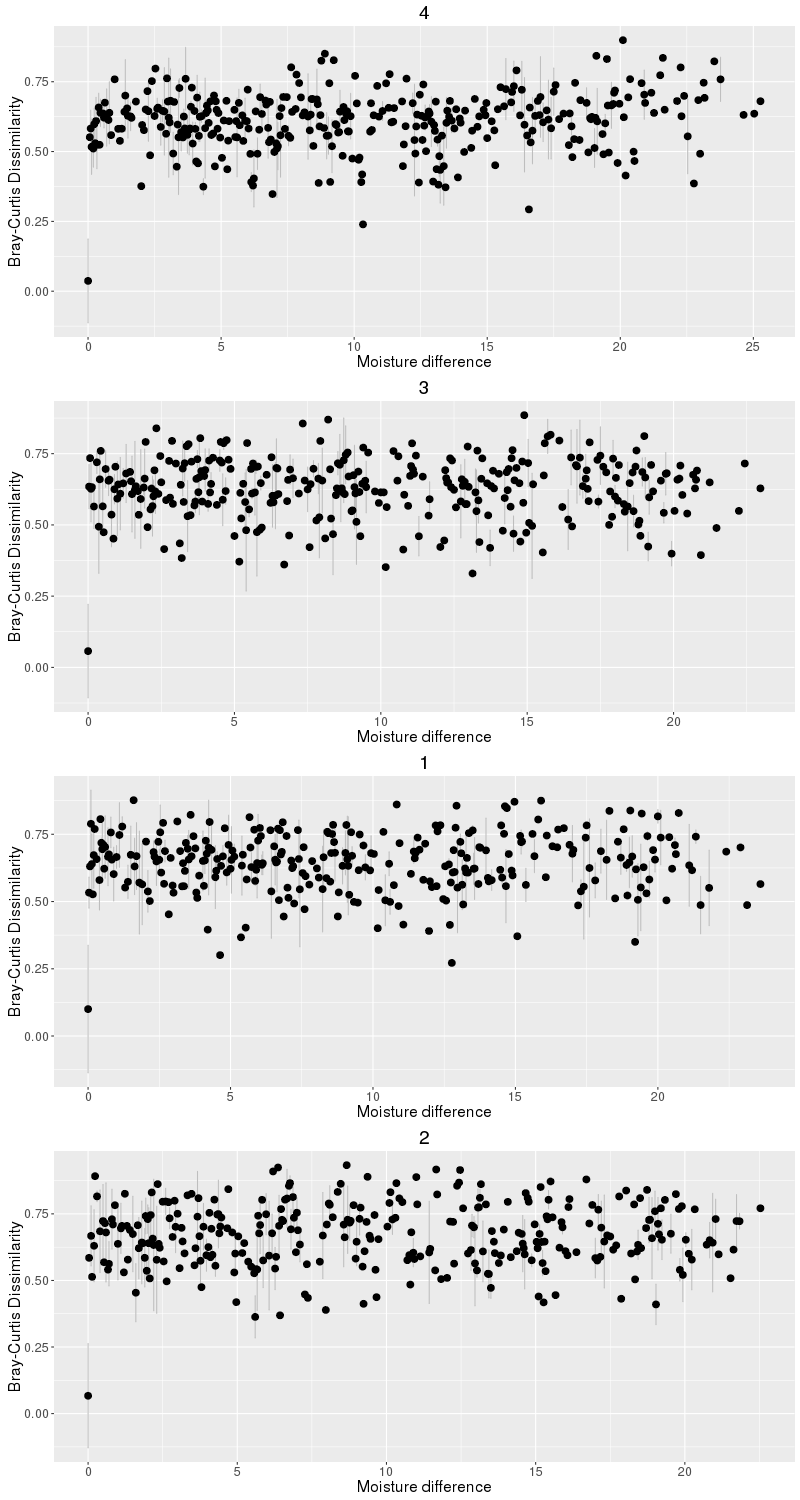

In [40]:
%%R -w 800 -h 1500
do.call(grid.arrange, c(plots,list(ncol=1)))

In [41]:
%%R
mantel.Temp = function(replicate, df.temp, df.dist) {
    
    df.t = df.temp[[as.character(replicate)]]
    df.d = df.dist[[as.character(replicate)]]

m = mantel(formula = df.d ~ df.t, nperm = 10000)
    
    return(m)
}

m.temp = lapply(replicates, df.temp = temp.dist, df.dist = MH.dist.rep.l, mantel.Temp)

In [42]:
%%R
#Results - replicates 4, 3, 1, 2
m.temp

[[1]]
   mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.09730984 0.05050000 0.94960000 0.07520000 0.03966564 0.14044087 

[[2]]
      mantelr         pval1         pval2         pval3     llim.2.5% 
 0.0001084202  0.4624000000  0.5377000000  0.9984000000 -0.0448989779 
   ulim.97.5% 
 0.0516145918 

[[3]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
-0.01764922  0.61910000  0.38100000  0.73640000 -0.05189821  0.01842126 

[[4]]
    mantelr       pval1       pval2       pval3   llim.2.5%  ulim.97.5% 
 0.02457528  0.30860000  0.69150000  0.67570000 -0.01781385  0.07155322 

